In [1]:
# FULL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
def calculate_within_tolerance(y_true, y_pred, tolerance):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    within_tolerance = np.abs(y_true - y_pred) / y_true <= tolerance
    percentage_within_tolerance = np.mean(within_tolerance) * 100
    return percentage_within_tolerance

In [3]:
# Load the datasets
data_path = '../13. Data from R 50000/'
X_train = pd.read_parquet(data_path + 'X_train_2024.parquet', engine='pyarrow')
X_test = pd.read_parquet(data_path + 'X_test_2024.parquet', engine='pyarrow')
seed_num = 2024

# Load y_train and y_test
y_train = pd.read_parquet(data_path + 'y_train_2024.parquet').iloc[:, 0]
y_test = pd.read_parquet(data_path + 'y_test_2024.parquet').iloc[:, 0]

# List of categorical variables
categorical_vars = [
    "MARITALSTATUS", "NOOFCHILDREN", "HOMEOWNERIND", "VEHICLE_LEFTORRIGHTHANDDRIVE",
    "DRIVER1_LICENCETYPE", "DRIVER2_LICENCETYPE", "DRIVER3_LICENCETYPE", "DRIVER4_LICENCETYPE",
    "DRIVER1_OTHERVEHICLEOWNEDIND", "DRIVER2_OTHERVEHICLEOWNEDIND", "DRIVER3_OTHERVEHICLEOWNEDIND",
    "DRIVER4_OTHERVEHICLEOWNEDIND", "MONTHLYPAYMENTSIND", "VEHICLE_USE_TYPE", "VEHICLEOVERNIGHTLOCATION",
    "VEHICLE_OWNERSHIP", "VEHICLE_MODIFIEDIND", "VEHICLE_BODYTYPE", "VEHICLE_FUELTYPE",
    "VEHICLE_TRANSMISSIONTYPE", "INDICATOR_NRCONVICTIONS_RECENT", "INDICATOR_CLAIMSCOUNT_RECENT"
]

# Define numerical columns by excluding categorical ones
numerical_vars = [col for col in X_train.columns if col not in categorical_vars]

# Dictionaries to store models, predictions, errors, and subset sizes
model_store = {}
prediction_store = {}
errors_store = {}
subset_sizes = {}

# Initialize lists to store the combined true values and predictions across all datasets
all_y_test_global = []
all_y_pred_global = []

# Function to calculate percentage within tolerance
def calculate_within_tolerance(y_true, y_pred, tolerance):
    within_tolerance = abs(y_true - y_pred) / y_true <= tolerance
    percentage_within_tolerance = within_tolerance.mean() * 100
    return percentage_within_tolerance

# Initialize dictionaries to store total weighted MSE and percentages within tolerance for each cluster
total_weighted_mse = {}
total_within_10 = {}
total_within_50 = {}
total_within_100 = {}

# Processing datasets
for i in range(2, 11):  # Loop from 2 to 10 clusters
    X_train_additional = pd.read_parquet(f'{data_path}X_train_proto_gower_c{i}_seed_2024.parquet')
    X_test_additional = pd.read_parquet(f'{data_path}X_test_proto_gower_c{i}_seed_2024.parquet')
    
    # Append the last columns to the main datasets
    X_train[f'additional_feature_{i}'] = X_train_additional.iloc[:, -1]
    X_test[f'additional_feature_{i}'] = X_test_additional.iloc[:, -1]

    # Initialize error storage for this dataset
    errors_store[i] = {}
    subset_sizes[i] = {}
    
    # Unique values in the 'additional_feature' column
    unique_values = X_train[f'additional_feature_{i}'].unique()

    # Initialize lists to store the combined true values and predictions for this dataset
    dataset_y_test = []
    dataset_y_pred = []
    
    # Initialize metrics lists
    mse_list = []
    mae_list = []
    rmse_list = []
    mape_list = []
    rmspe_list = []
    r2_list = []
    segment_sizes = []

    for value in unique_values:
        # Split the data by 'additional_feature'
        X_train_subset = X_train[X_train[f'additional_feature_{i}'] == value]
        X_test_subset = X_test[X_test[f'additional_feature_{i}'] == value]
        y_train_subset = y_train[X_train[f'additional_feature_{i}'] == value]
        y_test_subset = y_test[X_test[f'additional_feature_{i}'] == value]

        # Initialize and train the XGBoost model
        model = XGBRegressor(random_state=2024)
        model.fit(X_train_subset.drop(columns=[f'additional_feature_{i}']), y_train_subset)
        model_store[(i, value)] = model

        # Predict on the corresponding test set
        y_pred_subset = model.predict(X_test_subset.drop(columns=[f'additional_feature_{i}']))
        prediction_store[(i, value)] = y_pred_subset

        # Combine predictions and true values for this dataset
        dataset_y_test.extend(y_test_subset.tolist())
        dataset_y_pred.extend(y_pred_subset.tolist())

        # Calculate metrics for this subset
        mse = mean_squared_error(y_test_subset, y_pred_subset)
        mae = mean_absolute_error(y_test_subset, y_pred_subset)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test_subset - y_pred_subset) / y_test_subset)) * 100
        rmspe = np.sqrt(np.mean(np.square((y_test_subset - y_pred_subset) / y_test_subset))) * 100
        r2 = r2_score(y_test_subset, y_pred_subset)

        # Store differences for plotting
        differences = y_pred_subset - y_test_subset
        errors_store[i][value] = differences
        subset_sizes[i][value] = len(y_test_subset)
        
        # Append metrics and segment size to lists
        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
        rmspe_list.append(rmspe)
        r2_list.append(r2)
        segment_sizes.append(len(y_test_subset))

        # Print metrics for each subset
        print(f"Dataset {i}, Value {value}:")
        print(f"  MSE: {mse:.2f}")
        print(f"  MAE: {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAPE: {mape:.2f}%")
        print(f"  RMSPE: {rmspe:.2f}%")
        print(f"  R^2: {r2:.2f}")

    # Convert combined lists to numpy arrays for overall evaluation for this dataset
    dataset_y_test = np.array(dataset_y_test)
    dataset_y_pred = np.array(dataset_y_pred)

    # Combine the current dataset predictions with the global lists
    all_y_test_global.extend(dataset_y_test)
    all_y_pred_global.extend(dataset_y_pred)

    # Calculate overall metrics for the current dataset
    overall_mse = mean_squared_error(dataset_y_test, dataset_y_pred)
    overall_mae = mean_absolute_error(dataset_y_test, dataset_y_pred)
    overall_rmse = np.sqrt(overall_mse)
    overall_mape = np.mean(np.abs((dataset_y_test - dataset_y_pred) / dataset_y_test)) * 100
    overall_rmspe = np.sqrt(np.mean(np.square((dataset_y_test - dataset_y_pred) / dataset_y_test))) * 100
    overall_r2 = r2_score(dataset_y_test, dataset_y_pred)

    # Calculate percentage within tolerance for the current dataset
    overall_within_10 = calculate_within_tolerance(dataset_y_test, dataset_y_pred, 0.10)
    overall_within_50 = calculate_within_tolerance(dataset_y_test, dataset_y_pred, 0.50)
    overall_within_100 = calculate_within_tolerance(dataset_y_test, dataset_y_pred, 1.00)

    # Calculate weighted MSE for this dataset
    total_weighted_mse[i] = np.sum(np.array(mse_list) * np.array(segment_sizes)) / np.sum(segment_sizes)
    
    # Store percentages within tolerance for this dataset
    total_within_10[i] = overall_within_10
    total_within_50[i] = overall_within_50
    total_within_100[i] = overall_within_100

    # Add overall dataset differences for plotting (optional)
    errors_store[i]['overall'] = dataset_y_pred - dataset_y_test

    # Display overall metrics for the current dataset
    print(f"\nOverall Metrics for Dataset {i}:")
    print(f"  MSE: {overall_mse:.2f}")
    print(f"  MAE: {overall_mae:.2f}")
    print(f"  RMSE: {overall_rmse:.2f}")
    print(f"  MAPE: {overall_mape:.2f}%")
    print(f"  RMSPE: {overall_rmspe:.2f}%")
    print(f"  R^2: {overall_r2:.2f}")
    print(f"  Percentage within 10%: {overall_within_10:.2f}%")
    print(f"  Percentage within 50%: {overall_within_50:.2f}%")
    print(f"  Percentage within 100%: {overall_within_100:.2f}%")

Dataset 2, Value 1:
  MSE: 126918.02
  MAE: 255.91
  RMSE: 356.26
  MAPE: 25.21%
  RMSPE: 36.17%
  R^2: 0.74
Dataset 2, Value 2:
  MSE: 78724.52
  MAE: 173.67
  RMSE: 280.58
  MAPE: 22.64%
  RMSPE: 31.68%
  R^2: 0.76

Overall Metrics for Dataset 2:
  MSE: 102175.48
  MAE: 213.69
  RMSE: 319.65
  MAPE: 23.89%
  RMSPE: 33.94%
  R^2: 0.77
  Percentage within 10%: 30.60%
  Percentage within 50%: 89.51%
  Percentage within 100%: 98.41%
Dataset 3, Value 1:
  MSE: 133746.48
  MAE: 257.93
  RMSE: 365.71
  MAPE: 22.77%
  RMSPE: 33.99%
  R^2: 0.74
Dataset 3, Value 3:
  MSE: 116920.94
  MAE: 240.48
  RMSE: 341.94
  MAPE: 25.79%
  RMSPE: 37.18%
  R^2: 0.73
Dataset 3, Value 2:
  MSE: 66201.73
  MAE: 152.41
  RMSE: 257.30
  MAPE: 22.68%
  RMSPE: 32.13%
  R^2: 0.70

Overall Metrics for Dataset 3:
  MSE: 102190.46
  MAE: 211.96
  RMSE: 319.67
  MAPE: 23.87%
  RMSPE: 34.57%
  R^2: 0.77
  Percentage within 10%: 32.08%
  Percentage within 50%: 89.59%
  Percentage within 100%: 98.06%
Dataset 4, Value 4:
 

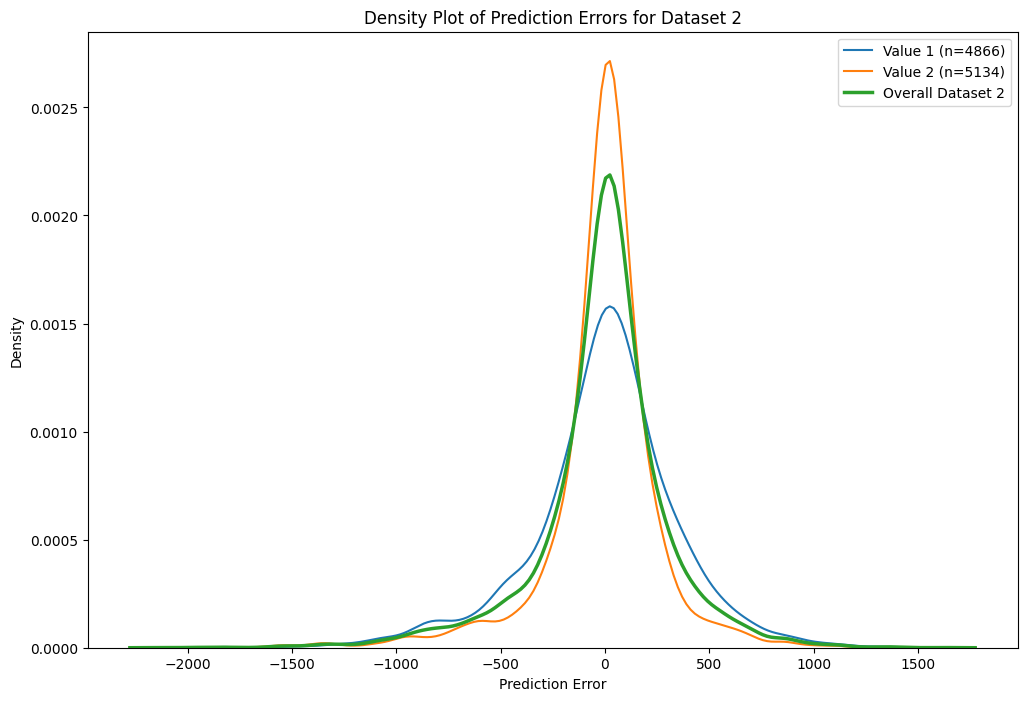

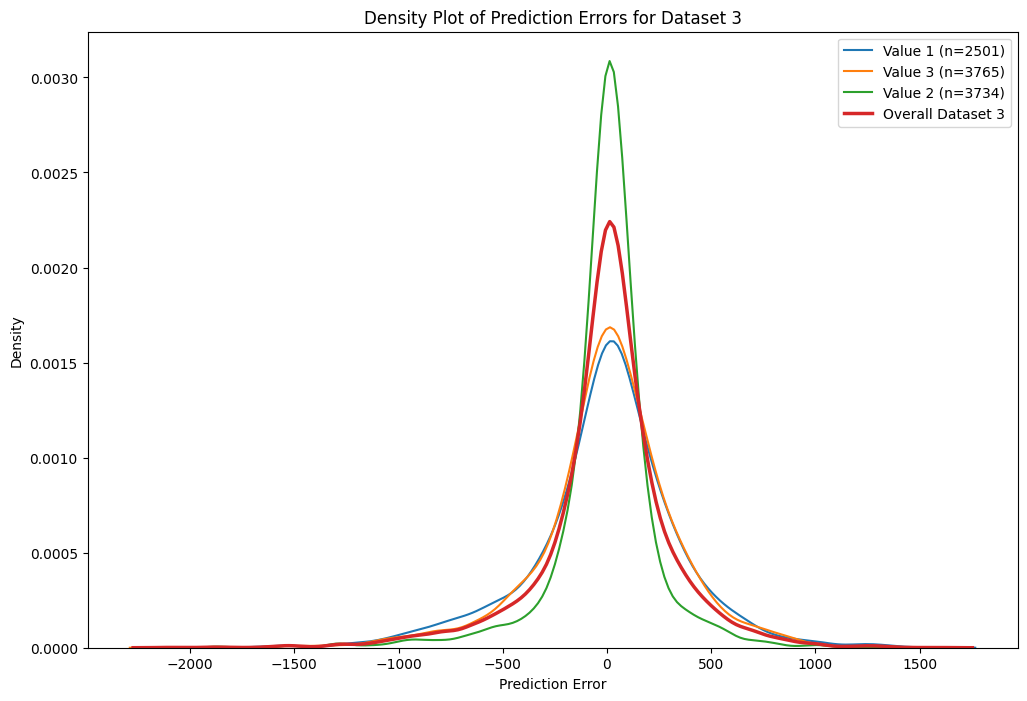

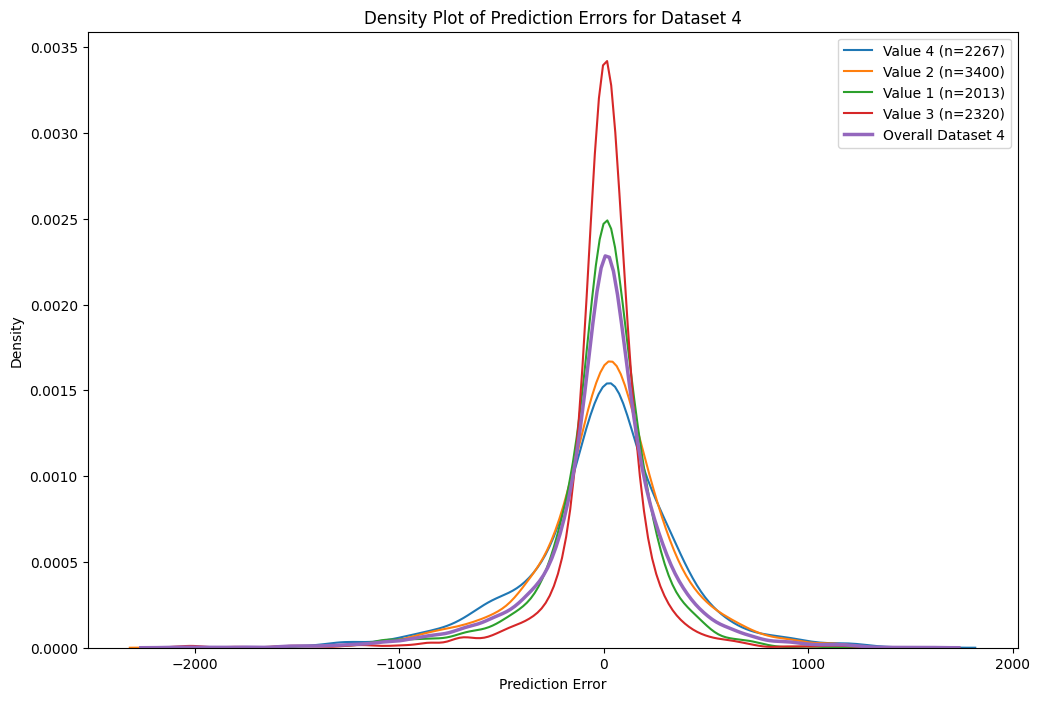

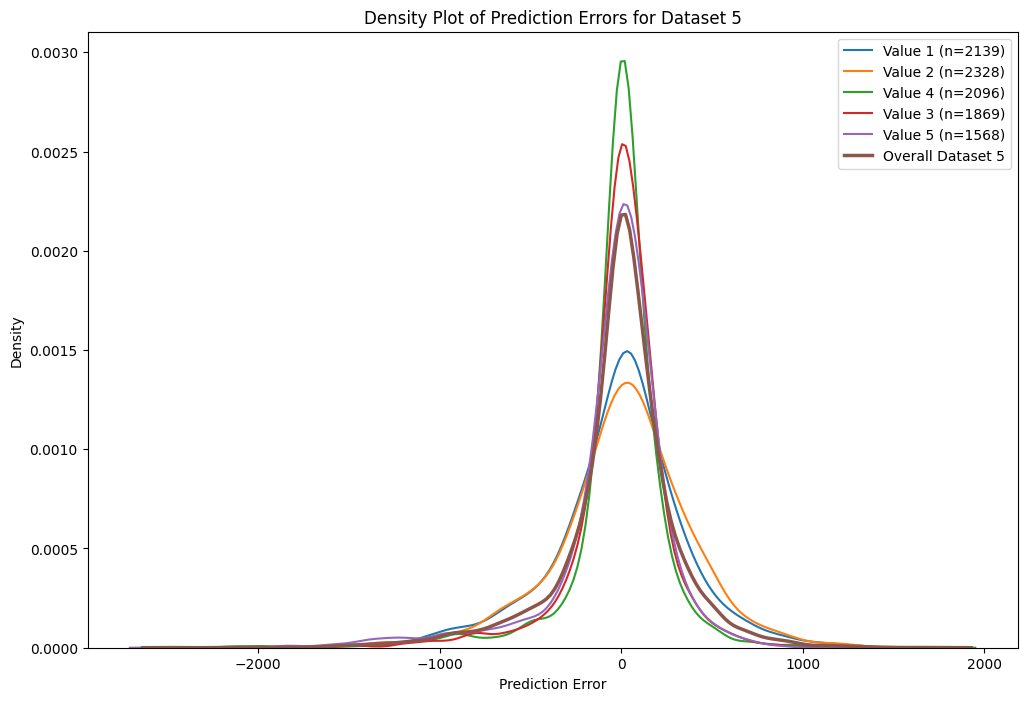

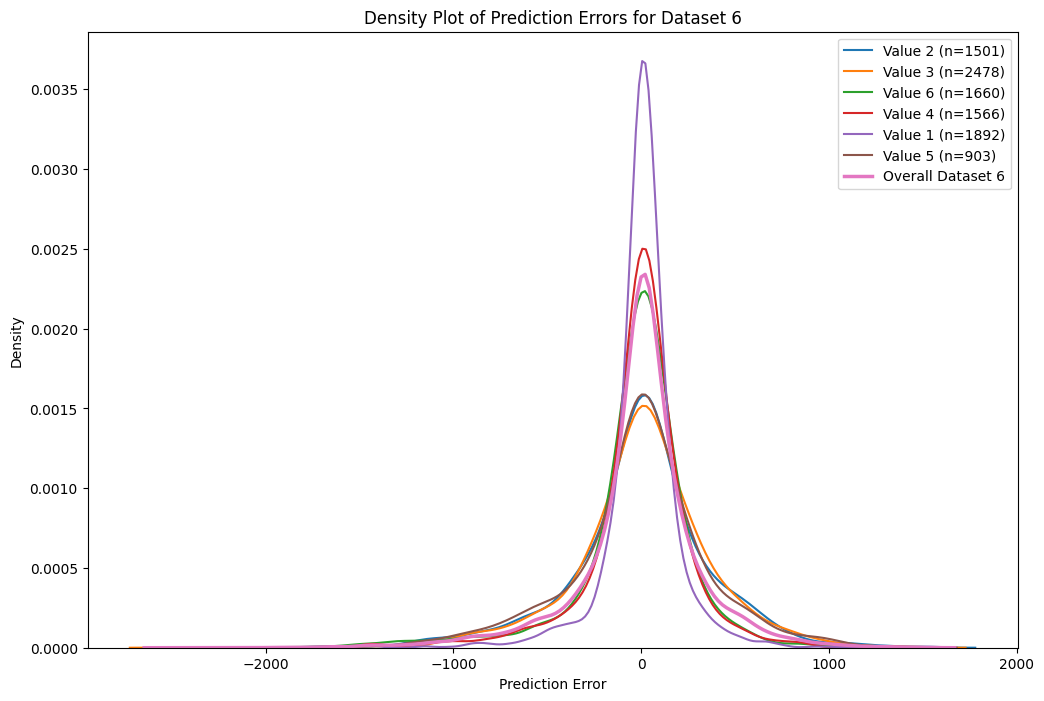

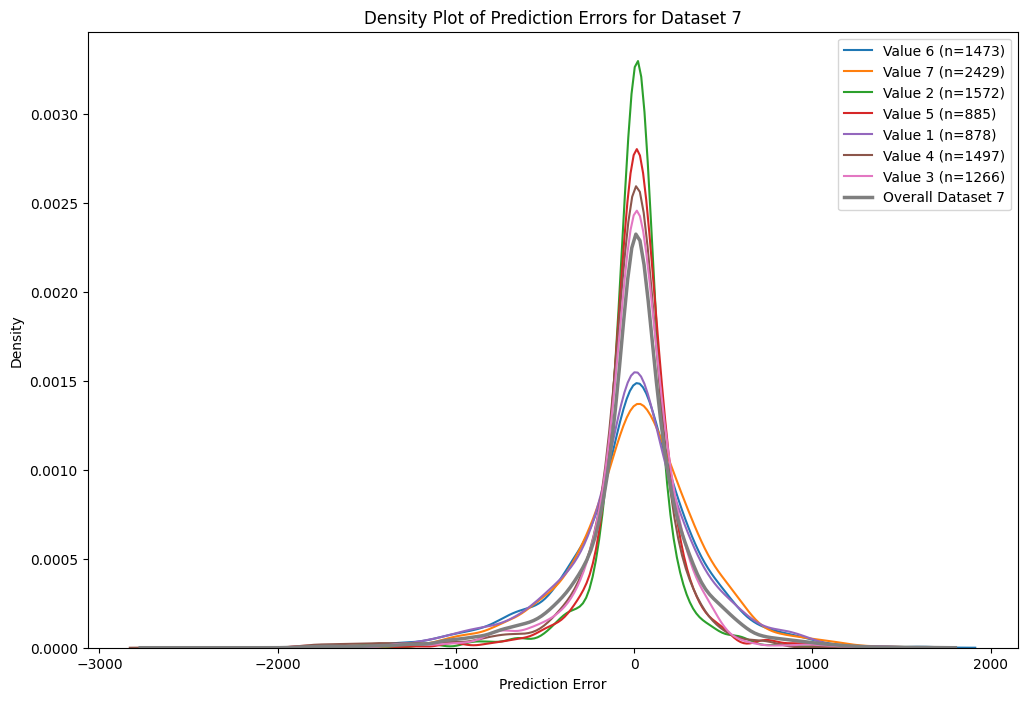

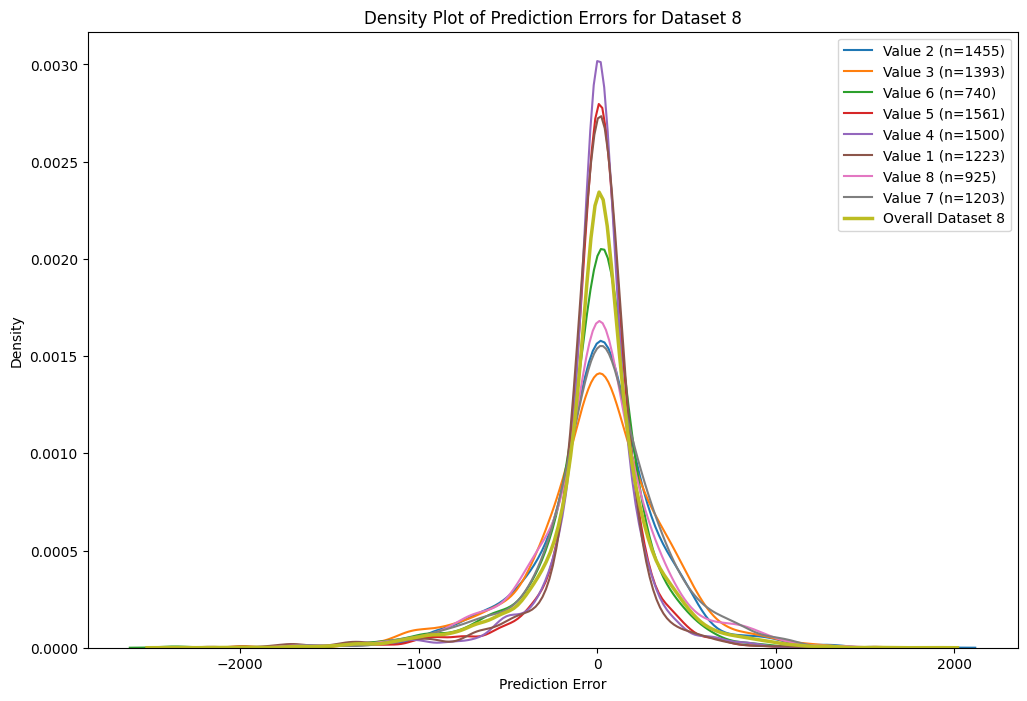

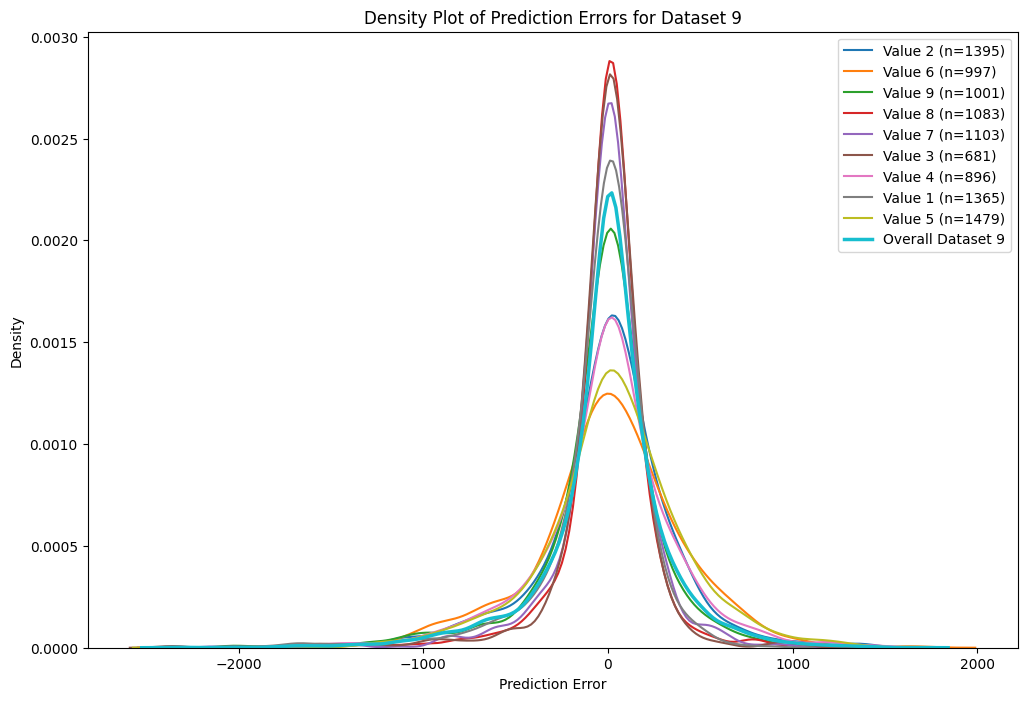

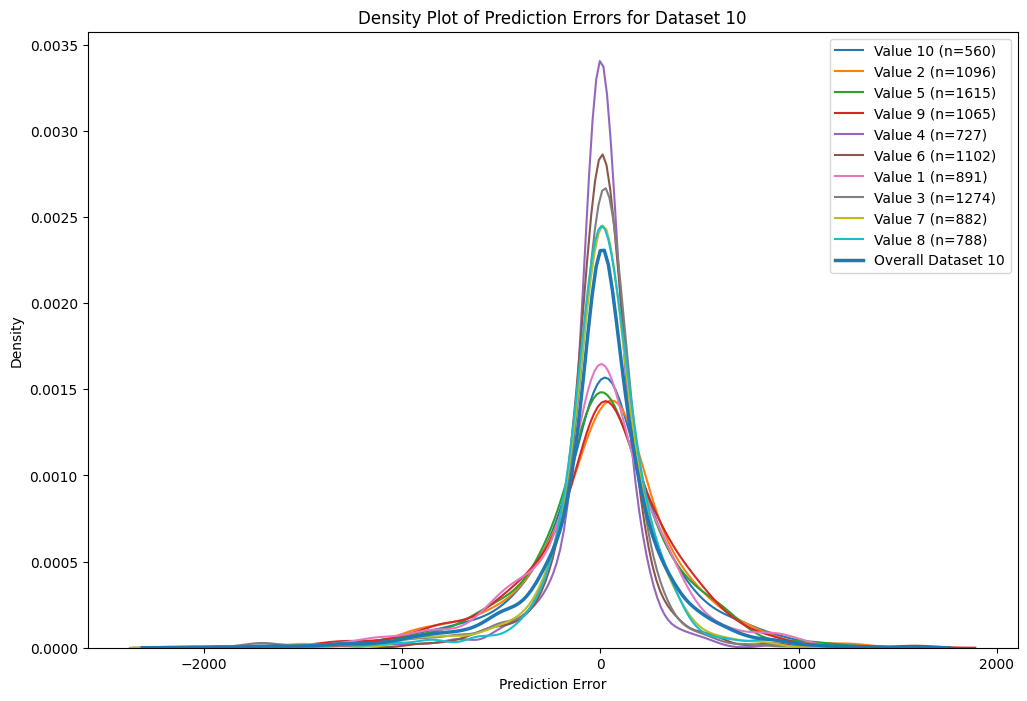

In [4]:
# Plotting density curves of prediction errors for each dataset
for i in errors_store:
    plt.figure(figsize=(12, 8))
    for value, errors in errors_store[i].items():
        if value == 'overall':
            sns.kdeplot(errors, label=f'Overall Dataset {i}', linewidth=2.5)
        else:
            sns.kdeplot(errors, label=f'Value {value} (n={subset_sizes[i][value]})')
    plt.title(f'Density Plot of Prediction Errors for Dataset {i}')
    plt.xlabel('Prediction Error')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

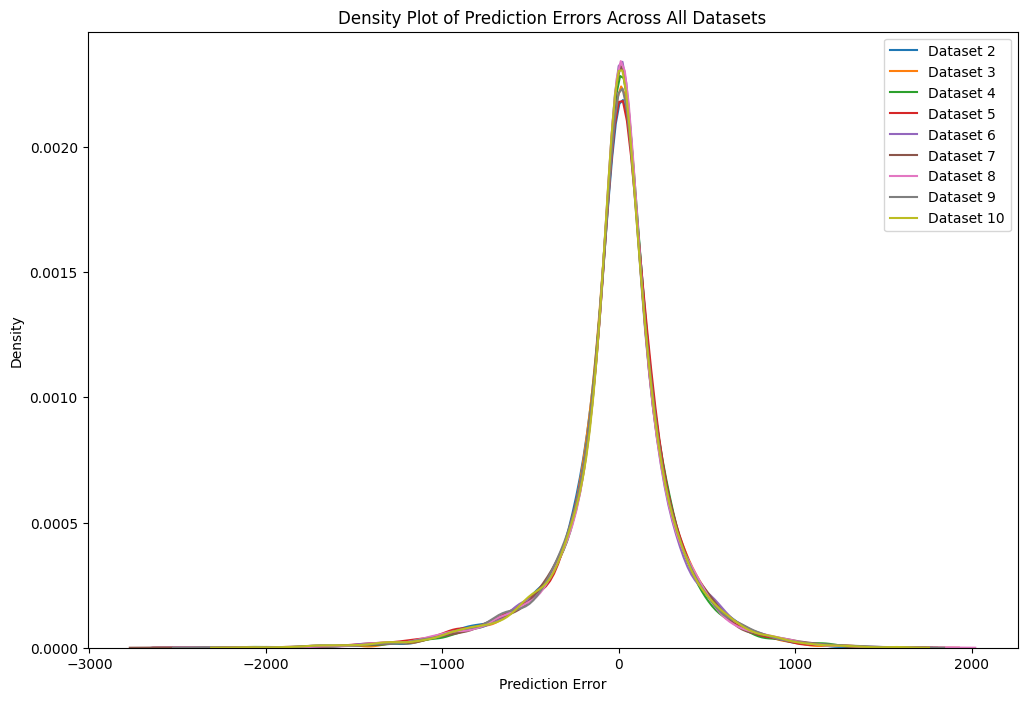

In [5]:
# Plotting density curves of prediction errors for each dataset
plt.figure(figsize=(12, 8))
for i in errors_store:
    sns.kdeplot(errors_store[i]['overall'], label=f'Dataset {i}')
plt.title('Density Plot of Prediction Errors Across All Datasets')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.legend()
plt.show()

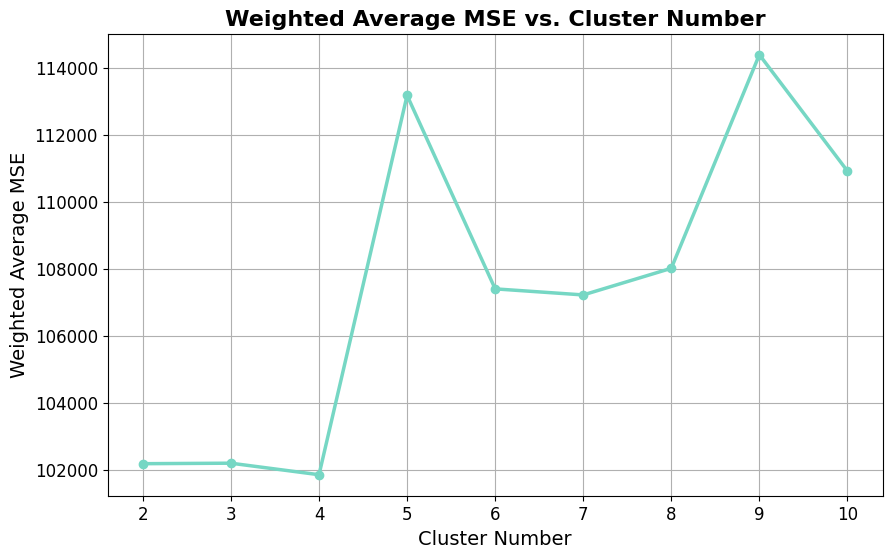

In [6]:
# Plotting Weighted Average MSE vs. Cluster Number
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), [total_weighted_mse[i] for i in range(2, 11)], marker='o', linestyle='-', color='#76D7C4', linewidth=2.5)
plt.title('Weighted Average MSE vs. Cluster Number', fontsize=16, weight='bold')
plt.xlabel('Cluster Number', fontsize=14)
plt.ylabel('Weighted Average MSE', fontsize=14)
plt.grid(True)
plt.xticks(range(2, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.show()


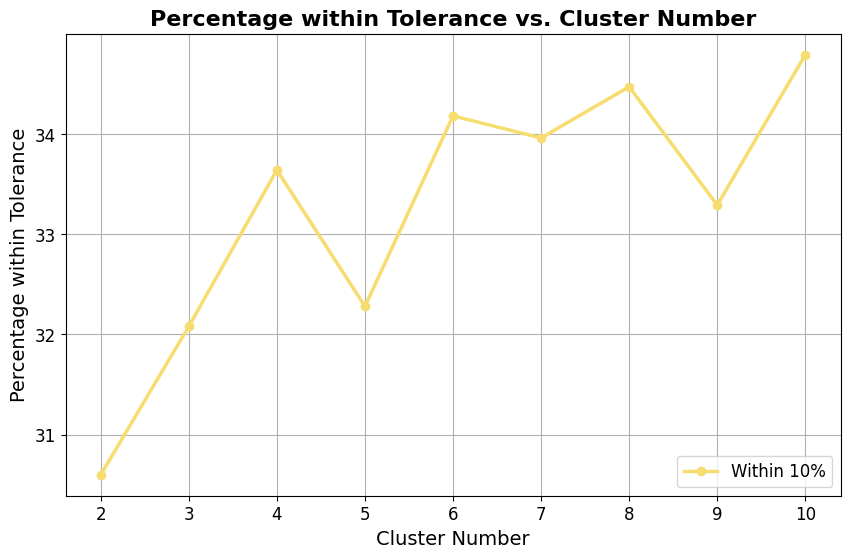

In [7]:
# Plotting Percentages within 10%, 50%, and 100% vs. Cluster Number
plt.figure(figsize=(10, 6))

# Plot for Percentage within 10%
plt.plot(range(2, 11), [total_within_10[i] for i in range(2, 11)], marker='o', linestyle='-', color='#F7DC6F', linewidth=2.5, label='Within 10%')

# Plot for Percentage within 50%
#plt.plot(range(2, 11), [total_within_50[i] for i in range(2, 11)], marker='o', linestyle='-', color='#F7DC6F', linewidth=2.5, label='Within 50%')

# Plot for Percentage within 100%
#plt.plot(range(2, 11), [total_within_100[i] for i in range(2, 11)], marker='o', linestyle='-', color='#F1948A', linewidth=2.5, label='Within 100%')

plt.title('Percentage within Tolerance vs. Cluster Number', fontsize=16, weight='bold')
plt.xlabel('Cluster Number', fontsize=14)
plt.ylabel('Percentage within Tolerance', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(range(2, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.show()


Dataset c2:
Dataset c2 - Overall MSE: 99992.66
Dataset c2 - Percentage within 10%: 29.99%
Dataset c2 - Percentage within 50%: 89.62%
Dataset c2 - Percentage within 100%: 98.36%
Dataset c3:
Dataset c3 - Overall MSE: 98490.63
Dataset c3 - Percentage within 10%: 30.86%
Dataset c3 - Percentage within 50%: 89.62%
Dataset c3 - Percentage within 100%: 98.44%
Dataset c4:
Dataset c4 - Overall MSE: 100218.55
Dataset c4 - Percentage within 10%: 30.41%
Dataset c4 - Percentage within 50%: 89.85%
Dataset c4 - Percentage within 100%: 98.37%
Dataset c5:
Dataset c5 - Overall MSE: 99506.01
Dataset c5 - Percentage within 10%: 30.24%
Dataset c5 - Percentage within 50%: 89.49%
Dataset c5 - Percentage within 100%: 98.21%
Dataset c6:
Dataset c6 - Overall MSE: 99399.94
Dataset c6 - Percentage within 10%: 30.25%
Dataset c6 - Percentage within 50%: 89.87%
Dataset c6 - Percentage within 100%: 98.26%
Dataset c7:
Dataset c7 - Overall MSE: 99899.37
Dataset c7 - Percentage within 10%: 29.96%
Dataset c7 - Percentage 

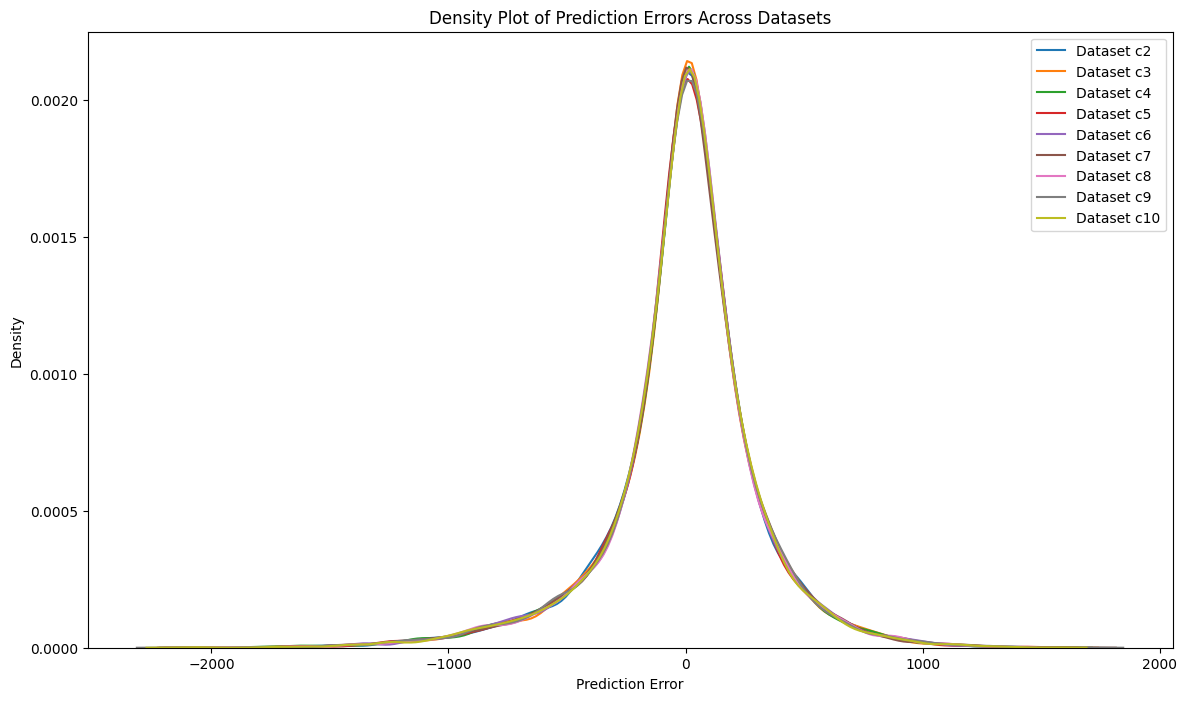

In [8]:
##### Predict clustered datasets overall, cluster results are used as features

# Load the datasets
X_train_base = pd.read_parquet(data_path + 'X_train_2024.parquet', engine='pyarrow')
X_test_base = pd.read_parquet(data_path + 'X_test_2024.parquet', engine='pyarrow')

# List of categorical variables
categorical_vars = ["MARITALSTATUS", "NOOFCHILDREN", "HOMEOWNERIND", "VEHICLE_LEFTORRIGHTHANDDRIVE",
                    "DRIVER1_LICENCETYPE", "DRIVER2_LICENCETYPE", "DRIVER3_LICENCETYPE", "DRIVER4_LICENCETYPE",
                    "DRIVER1_OTHERVEHICLEOWNEDIND", "DRIVER2_OTHERVEHICLEOWNEDIND", "DRIVER3_OTHERVEHICLEOWNEDIND",
                    "DRIVER4_OTHERVEHICLEOWNEDIND", "MONTHLYPAYMENTSIND", "VEHICLE_USE_TYPE", "VEHICLEOVERNIGHTLOCATION",
                    "VEHICLE_OWNERSHIP", "VEHICLE_MODIFIEDIND", "VEHICLE_BODYTYPE", "VEHICLE_FUELTYPE",
                    "VEHICLE_TRANSMISSIONTYPE", "INDICATOR_NRCONVICTIONS_RECENT", "INDICATOR_CLAIMSCOUNT_RECENT"]

# Define numerical columns by excluding categorical ones
numerical_vars = [col for col in X_train_base.columns if col not in categorical_vars]

# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the numerical columns of X_train_base and transform X_train_base and X_test_base
X_train_base[numerical_vars] = scaler.fit_transform(X_train_base[numerical_vars])
X_test_base[numerical_vars] = scaler.transform(X_test_base[numerical_vars])

# Load y_train and y_test
y_train = pd.read_parquet(data_path + 'y_train_2024.parquet').iloc[:, 0]
y_test = pd.read_parquet(data_path + 'y_test_2024.parquet').iloc[:, 0]

# Initialize storage for dataset-wide models
dataset_model_store = {}
dataset_predictions = {}
dataset_errors = {}
dataset_mse = {}

# Initialize storage for metrics
dataset_within_10 = {}
dataset_within_50 = {}
dataset_within_100 = {}

# Prepare to plot all density curves in one figure
plt.figure(figsize=(14, 8))

# Processing datasets
for i in range(2, 11):  # Loop from 2 to 10
    X_train = X_train_base.copy()
    X_test = X_test_base.copy()

    # Load the additional datasets
    X_train_additional = pd.read_parquet(f'{data_path}X_train_proto_gower_c{i}_seed_2024.parquet')
    X_test_additional = pd.read_parquet(f'{data_path}X_test_proto_gower_c{i}_seed_2024.parquet')

    # Append the last columns to the main datasets
    X_train[f'additional_feature_{i}'] = X_train_additional.iloc[:, -1]
    X_test[f'additional_feature_{i}'] = X_test_additional.iloc[:, -1]

    # Train and predict with XGBoost on the entire dataset (not split by additional feature)
    model = XGBRegressor(random_state=2024)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store dataset-wide results
    dataset_model_store[i] = model
    dataset_predictions[i] = y_pred
    errors = y_pred - y_test
    dataset_errors[i] = errors
    dataset_mse[i] = mean_squared_error(y_test, y_pred)
    sns.kdeplot(errors, label=f'Dataset c{i}')

    # Calculate metrics
    dataset_within_10[i] = calculate_within_tolerance(y_test, y_pred, 0.10)
    dataset_within_50[i] = calculate_within_tolerance(y_test, y_pred, 0.50)
    dataset_within_100[i] = calculate_within_tolerance(y_test, y_pred, 1.00)

    # Print metrics
    print(f"Dataset c{i}:")
    print(f"Dataset c{i} - Overall MSE: {dataset_mse[i]:.2f}")
    print(f"Dataset c{i} - Percentage within 10%: {dataset_within_10[i]:.2f}%")
    print(f"Dataset c{i} - Percentage within 50%: {dataset_within_50[i]:.2f}%")
    print(f"Dataset c{i} - Percentage within 100%: {dataset_within_100[i]:.2f}%")

    # # Plotting the density curve of the dataset-wide prediction errors
    # plt.figure(figsize=(10, 6))
    # sns.kdeplot(errors, label=f'Overall Dataset c{i}')
    # plt.title(f'Density Plot of Prediction Errors for Dataset c{i}')
    # plt.xlabel('Prediction Error')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()

# Finalize the plot
plt.title('Density Plot of Prediction Errors Across Datasets')
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.legend()
plt.show()
